# Kaggle Competition - Improving Zillow Zestimate

Submission by Robert Latimer

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
% matplotlib inline

We have four spreadsheets:
    * properties_2016.csv - all the properties with their home features for 2016.
    * train_2016_v2.csv - the training set with transactions from 1/1/2016 to 12/31/2016
    * sample_submission.csv - a sample submission file in the correct format
    * zillow_data_dictionary.xlsx - explains the data fields

The goal of this model is to improve the Zestimate residual error. More specifically, we are trying to minimize the mean absolute error between the predicted log error and the actual log error. This information is recorded in the transactions training data.

**logerror = log(Zestimate) − log(SalePrice)
 **
 
For each property (unique parcelid), we will predict a log error for each time point. We should be predicting 6 timepoints: **October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712)**. The file should contain a header and have the following format:

`ParcelId,201610,201611,201612,201710,201711,201712
10754147,0.1234,1.2234,-1.3012,1.4012,0.8642,3.1412
10759547,0,0,0,0,0,0
etc.`

## Let's start by vizualizing some of the data

### Transaction Data

In [5]:
transaction_data = pd.read_csv('train_2016_v2.csv', parse_dates =["transactiondate"])

In [10]:
transaction_data.head

<bound method DataFrame.head of        parcelid  logerror transactiondate
0      11016594    0.0276      2016-01-01
1      14366692   -0.1684      2016-01-01
2      12098116   -0.0040      2016-01-01
3      12643413    0.0218      2016-01-02
4      14432541   -0.0050      2016-01-02
5      11509835   -0.2705      2016-01-02
6      12286022    0.0440      2016-01-02
7      17177301    0.1638      2016-01-02
8      14739064   -0.0030      2016-01-02
9      14677559    0.0843      2016-01-03
10     10854446    0.3825      2016-01-03
11     11672170   -0.0161      2016-01-03
12     10949761    0.0344      2016-01-03
13     14665244    0.0816      2016-01-03
14     14148540   -0.0450      2016-01-03
15     14057104    0.0020      2016-01-03
16     17296797    0.0440      2016-01-03
17     12524288   -0.0419      2016-01-03
18     14091502   -0.0020      2016-01-03
19     10815909    0.0100      2016-01-03
20     12453853   -0.0387      2016-01-03
21     14253461    0.0218      2016-01-03
22

In [11]:
transaction_data.shape

(90275, 3)

This means there were 90,275 houses sold in 2016.

In [14]:
unique_props = len(transaction_data['parcelid'].unique())
multiple_sales = len(transaction_data) - unique_props
print unique_props
print multiple_sales

90150
125


Of the 90,275 total sales, 90,150 properties are were only sold once and 125 of the properties were sold more than once in 2016.

Now let's break the `'transactiondate'` column into separate columns to graph transactions over time.

In [16]:
transaction_data['sale_month'] = transaction_data['transactiondate'].apply(lambda x: (x.to_pydatetime()).month)
transaction_data['sale_day'] = transaction_data['transactiondate'].apply(lambda x: (x.to_pydatetime()).day)
transaction_data['sale_year'] = transaction_data['transactiondate'].apply(lambda x: (x.to_pydatetime()).year)

In [22]:
transaction_data.head(10)

,parcelid,logerror,transactiondate,sale_month,sale_day,sale_year
0,11016594,0.0276,2016-01-01,1,1,2016
1,14366692,-0.1684,2016-01-01,1,1,2016
2,12098116,-0.0040,2016-01-01,1,1,2016
3,12643413,0.0218,2016-01-02,1,2,2016
4,14432541,-0.0050,2016-01-02,1,2,2016
5,11509835,-0.2705,2016-01-02,1,2,2016
6,12286022,0.0440,2016-01-02,1,2,2016
7,17177301,0.1638,2016-01-02,1,2,2016
8,14739064,-0.0030,2016-01-02,1,2,2016
9,14677559,0.0843,2016-01-03,1,3,2016


Now let's graph the sales over time.

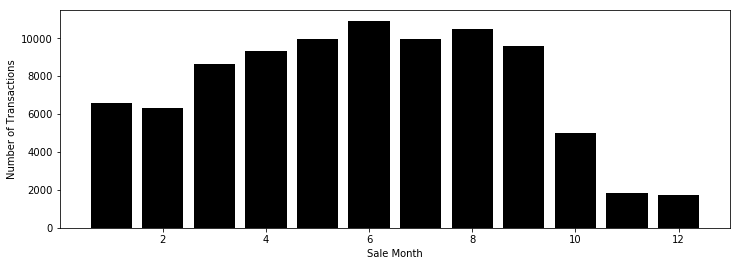

In [24]:
plt.figure(figsize=(12,4))
plt.bar(range(1,13),(transaction_data.groupby('sale_month').count())['parcelid'],color='k')
plt.xlabel('Sale Month')
plt.ylabel('Number of Transactions')

Here we can see that home sales are relatively seasonal. Most sales occur between March and September, with a considerable dropoff between October and February.

Now I'm curious to see what the average log error is month by month.

In [36]:
jan_transactions = transaction_data[transaction_data['sale_month'] == 1]['logerror']

In [37]:
jan_transactions.tail

<bound method Series.tail of 0       0.0276
1      -0.1684
2      -0.0040
3       0.0218
4      -0.0050
5      -0.2705
6       0.0440
7       0.1638
8      -0.0030
9       0.0843
10      0.3825
11     -0.0161
12      0.0344
13      0.0816
14     -0.0450
15      0.0020
16      0.0440
17     -0.0419
18     -0.0020
19      0.0100
20     -0.0387
21      0.0218
22      0.0149
23      0.1151
24     -0.1696
25     -0.0440
26     -0.0747
27      0.0080
28      0.0010
29     -0.0534
         ...  
6558    0.0129
6559   -0.0284
6560    0.0169
6561    0.0917
6562    0.0816
6563    0.0373
6564   -0.3496
6565    0.0178
6566   -0.0640
6567   -0.0408
6568   -0.0030
6569   -0.1233
6570    0.0188
6571   -0.0987
6572   -0.0171
6573   -0.0070
6574    0.0227
6575    0.0354
6576    0.0497
6577   -0.0523
6578    0.0440
6579    0.0109
6580    0.0119
6581    0.4240
6582   -0.0111
6583   -0.0050
6584   -0.0387
6585    0.0431
6586   -0.0243
6587   -0.0419
Name: logerror, Length: 6556, dtype: float64>

In [47]:
jan_log_error = np.mean([jan_transactions])
print np.around(jan_log_error,4)

0.0159


In [88]:
avg_logs_table = []

In [93]:
for i in range(1,13):
    avg_logs = np.mean(transaction_data[transaction_data['sale_month'] == i]['logerror'])
    avg_logs_table.append(avg_logs)
print avg_logs_table

[0.015869524100061077, 0.01608212537501983, 0.009866759130836856, 0.006605488132316614, 0.006925880935649025, 0.007172239516572072, 0.011687302704333059, 0.011572814051164615, 0.016255362924282046, 0.016341631504922665, 0.014510131434830202, 0.019122311673375463]


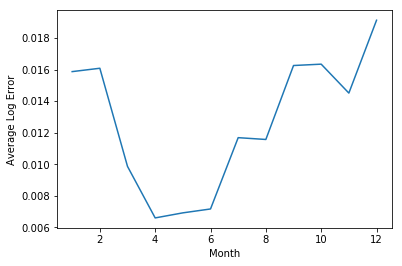

In [87]:
t = range(1,13)
plt.plot(t,avg_logs_table)
plt.xlabel('Month')
plt.ylabel('Average Log Error')

I realized that we took the mean, but our logerrors were both positive (property is overpriced) and negative (property was underestimated) values. Seeing how the average log error for each month is a positive value, however, we can conclude that Zillow's Zestimate is overvaluing home prices.

Let's try making a graph with the absolute value of the log errors.

In [113]:
abs_log_error_list = transaction_data[['logerror','sale_month']]
abs_log_error_list['logerror'] = np.abs(abs_log_error_list['logerror'])
#abs_log_errors = np.abs(abs_log_error_list['logerror'])
abs_log_error_list.head

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<bound method DataFrame.head of        logerror  sale_month
0        0.0276           1
1        0.1684           1
2        0.0040           1
3        0.0218           1
4        0.0050           1
5        0.2705           1
6        0.0440           1
7        0.1638           1
8        0.0030           1
9        0.0843           1
10       0.3825           1
11       0.0161           1
12       0.0344           1
13       0.0816           1
14       0.0450           1
15       0.0020           1
16       0.0440           1
17       0.0419           1
18       0.0020           1
19       0.0100           1
20       0.0387           1
21       0.0218           1
22       0.0149           1
23       0.1151           1
24       0.1696           1
25       0.0440           1
26       0.0747           1
27       0.0080           1
28       0.0010           1
29       0.0534           1
...         ...         ...
90245    0.0953          12
90246    0.0139          12
90247    0.2095 

In [114]:
avg_abs_logs_table = []
for i in range(1,13):
    avg_logs = np.mean(abs_log_error_list[abs_log_error_list['sale_month'] == i]['logerror'])
    avg_abs_logs_table.append(avg_logs)
print avg_abs_logs_table

[0.07269484441732726, 0.07743447023527479, 0.07204392048081316, 0.06997150681988983, 0.06624098986045543, 0.06615773667826351, 0.06504399316376759, 0.06610425735013294, 0.06727859007832837, 0.06474645368695962, 0.06396522453450172, 0.07595186889016677]


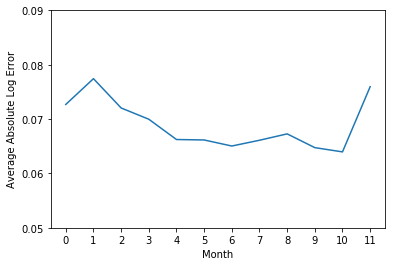

In [145]:
plt.plot(avg_abs_logs_table)
plt.xticks(np.linspace(0,11,12,endpoint=True))
plt.yticks(np.linspace(0.05,0.09,5,endpoint=True))
plt.xlabel('Month')
plt.ylabel('Average Absolute Log Error')

The average absolute log errors are highest in December, January, February and March. These are also months where fewer houses are sold. Speculating, one might hypothesize that selling prices during these months might be a bit more sparatic than other months. If a seller is trying to sell a home in December, when demand is lower than other months, the seller may be willing to accept an offer below market rather than hold onto the home for a few more months. 

In [146]:
import seaborn as sns
# histogram of log error
upper_limit = np.percentile(transaction_data.logerror.values, 99)
lower_limit = np.percentile(transaction_data.logerror.values, 1)

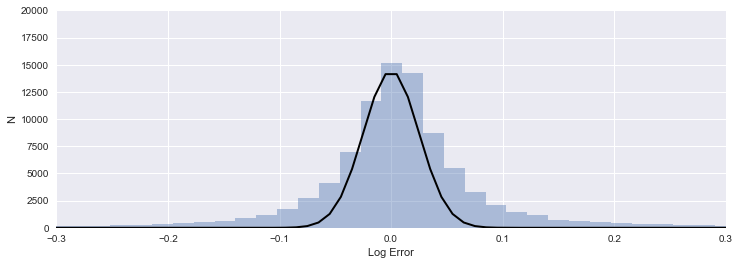

In [151]:
from scipy.stats import norm
plt.figure(figsize=(12,4))
sns.distplot(transaction_data.logerror.values, bins=500, kde=False)
plt.xlabel('Log Error')
mu, std = norm.fit(transaction_data.logerror.values)
xmin,xmax=plt.xlim()
x = np.linspace(-5,5,1000)
p = norm.pdf(x, 0, 0.025)
plt.plot(x, p*(x[1]-x[0])*90275, 'k', linewidth=2)
plt.axis([-0.3,0.3,0,20000])
plt.ylabel('N')

The log distribution does not follow a pure normal distribution.

## Property Data